In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as stats
from ast import literal_eval
from sklearn.preprocessing import StandardScaler

In [2]:
# read in csv files
best_picture = pd.read_csv('../data/best_picture.csv')
movies_2015_2024 = pd.read_csv('../data/movies_2015_2024.csv')
movies_merged = pd.read_csv('../data/movies_merged.csv')
merged_cpi = pd.read_csv('../data/merged_cpi.csv')
merged_genre_explode = pd.read_csv('../data/merged_genre_explode.csv')

> ## Linear Regression Model
>
> 
> In this notebook we are generating a **linear regression model** from our extracted movie data. First we will examine the data and do some exploatory analysis. When building linear regression models me make **four assumptions** in the data. We assume linearity, Indepence of errors, constant variance and normal distribution of errors. Below we explore this distribution.
>
> 
>* Create **scatter-plot** to examine data.
>* Explore residuals in our dataset.
>* create **Q-Q plot** for accurate estimates. 

In [3]:
# display data
movies_2015_2024.head()

,title,vote_average,vote_count,budget,revenue,imdb_id,id,movie_genres,release_year
0,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,"['Action', 'Horror', 'Science Fiction']",2020
1,10 Cloverfield Lane,6.994,8359,15000000,110216998,tt1179933,333371,"['Thriller', 'Science Fiction', 'Drama', 'Horr...",2016
2,12 Strong,6.300,3096,35000000,67450815,tt1413492,429351,"['War', 'Drama', 'Action', 'History']",2018
3,13 Hours: The Secret Soldiers of Benghazi,7.269,3789,50000000,69411370,tt4172430,300671,"['War', 'Action', 'History', 'Drama', 'Thriller']",2016
4,1917,7.986,13091,100000000,446064352,tt8579674,530915,"['War', 'History', 'Drama', 'Action']",2019


In [4]:
# view columns 
merged_cpi.columns

Index(['title', 'vote_average', 'vote_count', 'budget', 'revenue', 'imdb_id',
       'id', 'movie_genres', 'release_year', 'Winner', 'cpi_multiplier',
       'budget_2024', 'revenue_2024'],
      dtype='object')

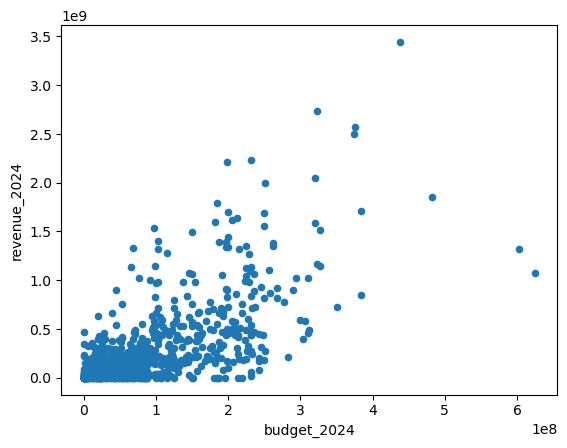

In [5]:
# examine distribution of values
merged_cpi.plot(
    kind = 'scatter',
    x = 'budget_2024',
    y = 'revenue_2024'
);

In [6]:
# create linear regression model
mov_lr = smf.ols(
    formula = 'revenue_2024 ~ budget_2024',
    data = merged_cpi
).fit()                                               

In [7]:
# show coefficients
mov_lr.params

Intercept      3.840048e+06
budget_2024    3.182607e+00
dtype: float64

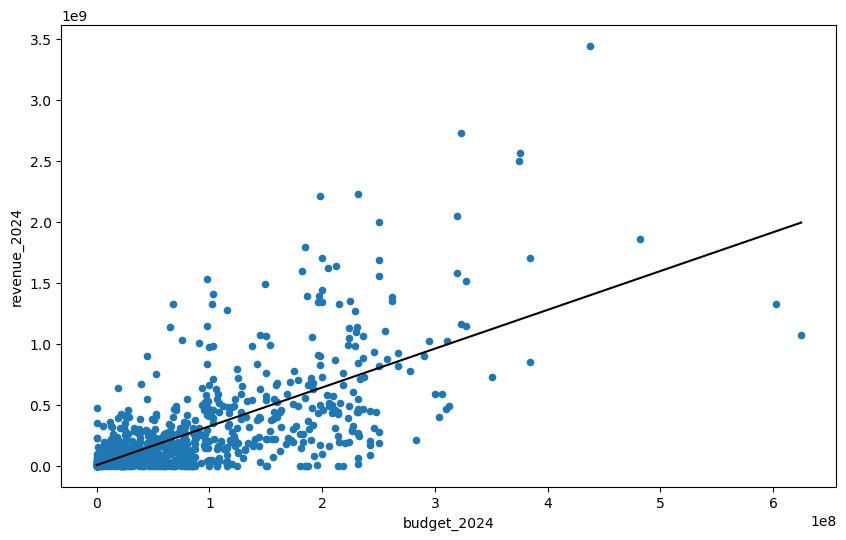

In [8]:
# fit line to data
x_pred = pd.DataFrame({'budget_2024': np.linspace(start = merged_cpi['budget_2024'].min(),
                                             stop = merged_cpi['budget_2024'].max(), 
                                             num = 250)
                      })

pred = mov_lr.predict(x_pred)

merged_cpi.plot(
    kind = 'scatter',
    x = 'budget_2024',
    y = 'revenue_2024',
    figsize = (10,6)
)

plt.plot(x_pred['budget_2024'], pred, color = 'black');

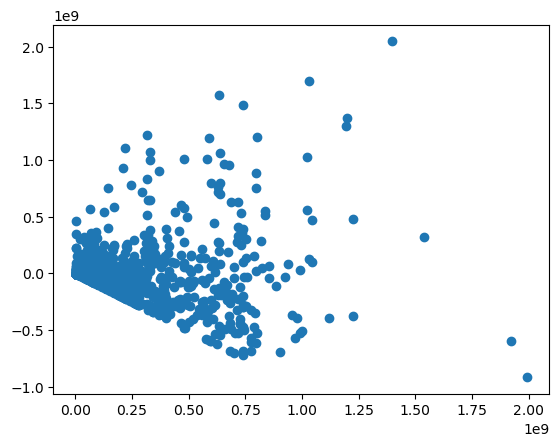

In [9]:
# show scatterplot of residuals
plt.scatter(x = mov_lr.fittedvalues, y = mov_lr.resid);

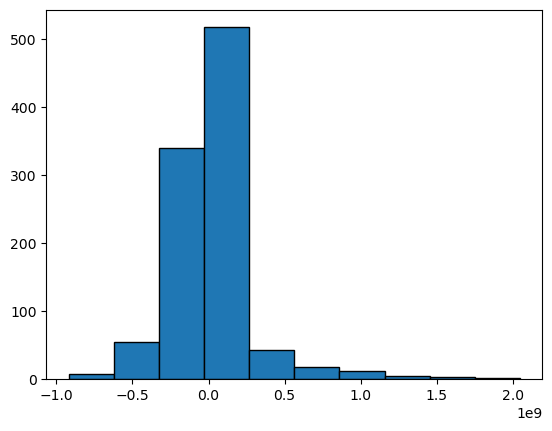

In [10]:
# plot residuals in model
plt.hist(mov_lr.resid, edgecolor = 'black');

In [11]:
from scipy.stats import probplot

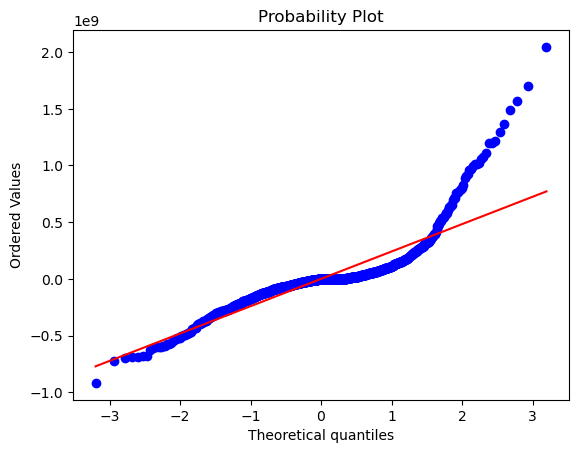

In [12]:
# create Q -Q plot to view residuals
probplot(mov_lr.resid, plot = plt);

> ## Expand Genre Variables
>
> 
> The dataset we have contains genres for **hundreds** of different movies. We want to expand these genre variables so we can get a better look at the overall effect of genre on the dataset. To do this we will **create dummy columns** in our data and assign binary variables to genre, thats **true or false.** After expanding these lists of genres we will merge it with our full dataframe to then create a new linear regression model using all genre variables.
>
> 
>* Expand list of genres in data.
>* Create **profit column** for multiple variable linear regression
>* **Join** with origional dataset for **exploration**.
>
>

In [13]:
# create profit column
genre_explode_profit = merged_genre_explode
genre_explode_profit['profit'] = genre_explode_profit['revenue'] - genre_explode_profit['budget']

In [14]:
# display new column
genre_explode_profit.head()

,title,vote_average,vote_count,budget,revenue,imdb_id,id,movie_genres,release_year,Winner,cpi_multiplier,budget_2024,revenue_2024,profit
0,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,Action,2020,No,1.21,7623000.0,1.623370e+07,7116285
1,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,Horror,2020,No,1.21,7623000.0,1.623370e+07,7116285
2,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,Science Fiction,2020,No,1.21,7623000.0,1.623370e+07,7116285
3,10 Cloverfield Lane,6.994,8359,15000000,110216998,tt1179933,333371,Thriller,2016,No,1.31,19650000.0,1.443843e+08,95216998
4,10 Cloverfield Lane,6.994,8359,15000000,110216998,tt1179933,333371,Science Fiction,2016,No,1.31,19650000.0,1.443843e+08,95216998


In [15]:
# look at shape
genre_explode_profit.shape

(2823, 14)

In [16]:
# normalize genre values
dummy_geners=pd.get_dummies(genre_explode_profit['movie_genres'])
dummy_geners.head(2)

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [17]:
# join dummy genre values to dataframe for regression model
dummy_genre_explode=movies_2015_2024.join(dummy_geners)
dummy_genre_explode.head(2)

,title,vote_average,vote_count,budget,revenue,imdb_id,id,movie_genres,release_year,Action,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,"['Action', 'Horror', 'Science Fiction']",2020,True,...,False,False,False,False,False,False,False,False,False,False
1,10 Cloverfield Lane,6.994,8359,15000000,110216998,tt1179933,333371,"['Thriller', 'Science Fiction', 'Drama', 'Horr...",2016,False,...,False,True,False,False,False,False,False,False,False,False


In [18]:
# create profit column
dummy_genre_explode['profit'] = dummy_genre_explode['revenue'] - dummy_genre_explode['budget']
dummy_genre_explode.head(2)

,title,vote_average,vote_count,budget,revenue,imdb_id,id,movie_genres,release_year,Action,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,profit
0,#Alive,7.227,1955,6300000,13416285,tt10620868,614696,"['Action', 'Horror', 'Science Fiction']",2020,True,...,False,False,False,False,False,False,False,False,False,7116285
1,10 Cloverfield Lane,6.994,8359,15000000,110216998,tt1179933,333371,"['Thriller', 'Science Fiction', 'Drama', 'Horr...",2016,False,...,True,False,False,False,False,False,False,False,False,95216998


In [19]:
# view columns
dummy_genre_explode.columns

Index(['title', 'vote_average', 'vote_count', 'budget', 'revenue', 'imdb_id',
       'id', 'movie_genres', 'release_year', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'profit'],
      dtype='object')

> ## Multiple Linear Regression
>
> 
> In this linear regression model we combine **multiple variables** to make our model more accurate. This model is built to predict profit based off of genre, budget, vote count, and vote average. In a linear regresion model we want a high **R-squared value.** The R squared value tells us how much of the variation of our outcome is explained by the models predictors. R squared tells us how well our model fits the data.
>
> 
>* **R-squared** value is **53%**
>* Genre coefficients are **not** statistically significant.
>* Genre does not have a significant impact on profit.
>* **Budget** has the largest impact on profit.
>
>

In [20]:
# fit model with all genres, budget, vote count and vote average
lr_dummy_genre_explode=smf.ols(
    'profit ~ budget + vote_count + vote_average + '
    'I(Action)+I(Adventure)+I(Animation)+I(Comedy)+'
    'I(Crime)+I(Documentary)+I(Drama)+I(Family)+'
    'I(Fantasy)+I(History)+I(Horror)+I(Music)+'
    'I(Mystery)+I(Romance)+Q("Science Fiction")+Q("TV Movie")+'
    'I(Thriller)+I(War)', data = dummy_genre_explode).fit()

lr_dummy_genre_explode.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     52.45
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          5.35e-144
Time:                        21:47:27   Log-Likelihood:                -20457.
No. Observations:                1000   AIC:                         4.096e+04
Df Residuals:                     978   BIC:                         4.106e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                    -2.703e+08   1.25e+08     -2.168      0.030   -5.15e+08   -2.57e+07
I(Action)[T.True]             2.274e+06    1.1e+08      0.021      0.983   -2.13e+08    2.17e+08
I(Adventure)[T.True]         -1.936e+07    1.1e+08     -0.176      0.860   -2.35e+08    1.96e+08
I(Animation)[T.True]          2.052e+07   1.15e+08      0.178      0.859   -2.05e+08    2.46e+08
I(Comedy)[T.True]             2.806e+07    1.1e+08      0.256      0.798   -1.87e+08    2.43e+08
I(Crime)[T.True]              1.335e+07   1.11e+08      0.120      0.905   -2.05e+08    2.32e+08
I(Documentary)[T.True]        5.793e+07   2.17e+08      0.268      0.789   -3.67e+08    4.83e+08
I(Drama)[T.True]              3.816e+07    1.1e+08      0.348      0.728   -1.77e+08    2.53e+08
I(Family)[T.True]             4.349e+07   1.13e+08      0.384      0.701   -1.79e+08    2.66e+08
I(Fantasy)[T.True]           -3.461e+07   1.11e+08     -0.311      0.756   -2.53e+08    1.84e+08
I(History)[T.True]            1.946e+06   1.15e+08      0.017      0.987   -2.24e+08    2.28e+08
I(Horror)[T.True]             2.129e+07   1.11e+08      0.192      0.847   -1.96e+08    2.38e+08
I(Music)[T.True]             -3.111e+07   1.22e+08     -0.254      0.799   -2.71e+08    2.09e+08
I(Mystery)[T.True]             3.69e+06   1.12e+08      0.033      0.974   -2.17e+08    2.24e+08
I(Romance)[T.True]            5.431e+07   1.11e+08      0.488      0.626   -1.64e+08    2.73e+08
Q("Science Fiction")[T.True]  1.178e+07    1.1e+08      0.107      0.915   -2.05e+08    2.28e+08
Q("TV Movie")[T.True]         3.323e+06   2.16e+08      0.015      0.988   -4.21e+08    4.28e+08
I(Thriller)[T.True]           -1.86e+06    1.1e+08     -0.017      0.987   -2.18e+08    2.14e+08
I(War)[T.True]                1.163e+07   1.22e+08      0.095      0.924   -2.28e+08    2.51e+08
budget                           1.0932      0.097     11.249      0.000       0.902       1.284
vote_count                    3.213e+04   1601.829     20.058      0.000     2.9e+04    3.53e+04
vote_average                  2.387e+07   9.63e+06      2.479      0.013    4.97e+06    4.28e+07
==============================================================================
Omnibus:                      501.009   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5404.680
Skew:                           2.037   Prob(JB):                         0.00
Kurtosis:                      13.636   Cond. No.                     7.55e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.55e+09. This might indicate that there are
stro

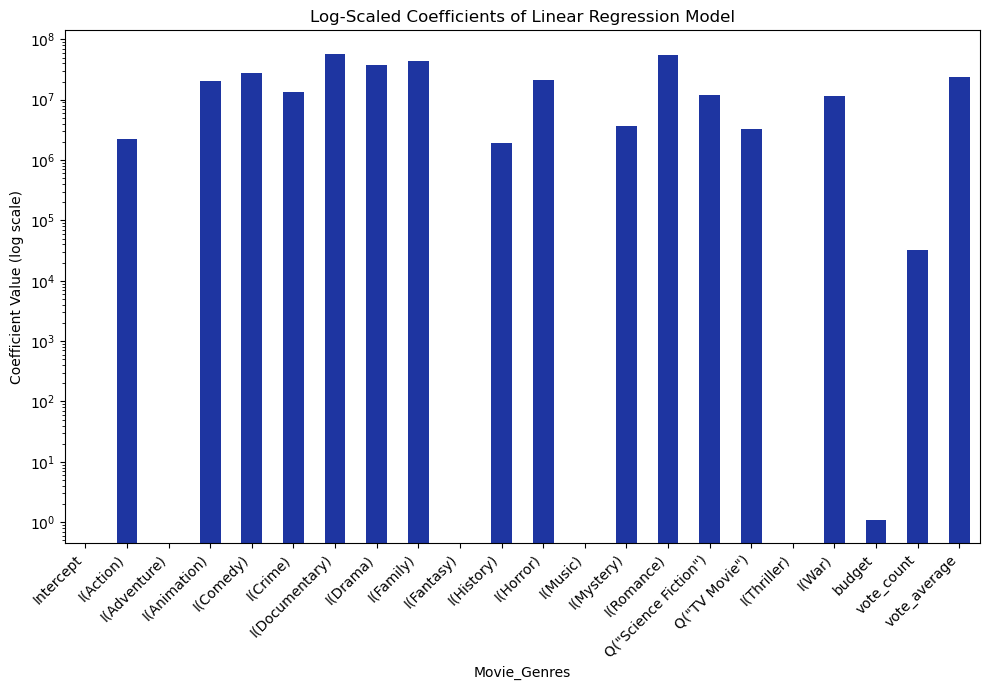

In [21]:
# import colors from powerpoint
dark_blue = "#1e35a1"

# plot linear regression model
params_renamed = lr_dummy_genre_explode.params.copy()

# filter variable names with regex
params_renamed.index= params_renamed.index.str.replace(r'\[T\.True\]', '', regex=True)

# adjust title and visualization
plt.figure(figsize=(10,7))
ax = params_renamed.plot(kind='bar', color=dark_blue)
ax.set_yscale('log')
ax.set_title('Log-Scaled Coefficients of Linear Regression Model')
ax.set_xlabel('Movie_Genres')
ax.set_ylabel('Coefficient Value (log scale)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../assets/Log-Scaled Coefficients of Linear Regression Model', dpi = 150);

plt.show()

> ## Model Optimization
>
> The previous model tells us that genre does not play a significant role in predicting movie profit. We have data in several categories and want to find which combonations best predict profit. Below we build a tool to create **every possible combination** of relevant variables. We save the P-values and R-Squared values to rank every possible linnear regression model. We then can find which combination of variables **best predicts movie profit.**
>
> 
>* Optimize linear regression to best predict profit.
>* Sort combinations of useful variables.
>* Rank combinations based on Adjusted R-Squared values.
>
> 

In [33]:
# display columns
dummy_genre_explode.columns

Index(['title', 'vote_average', 'vote_count', 'budget', 'revenue', 'imdb_id',
       'id', 'movie_genres', 'release_year', 'Action', 'Adventure',
       'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family',
       'Fantasy', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western', 'profit'],
      dtype='object')

In [35]:
# import combination tool
from itertools import combinations

# create response variable
response_var = "profit"

# assemble pool of data to create better prediction
predictor_pool = [
    "budget", 
    "vote_count", 
    "vote_average",
    "release_year"
]
   
# choose number of variables in model
combination_sizes = [2, 3, 4]

results = []

for r in combination_sizes:
    for combo in combinations(predictor_pool, r):
        
        predictors_str = " + ".join(combo)
        formula = f"{response_var} ~ {predictors_str}"
        
        model = smf.ols(formula=formula, data=dummy_genre_explode).fit()
        
        row = {
            "predictors": combo,
            "formula": formula,
            "num_predictors": r,
            "r_squared": model.rsquared,
            "adj_r_squared": model.rsquared_adj
        }
        
        # store coefficients
        for name, coef in model.params.items():
            row[f"coef_{name}"] = coef
        
        # store p-values
        for name, pval in model.pvalues.items():
            row[f"p_{name}"] = pval
        
        results.append(row)

# convert list to dataframe
model_results_df = pd.DataFrame(results)

# sort by adjusted r squared values
model_results_df_sorted = model_results_df.sort_values(
    "adj_r_squared", ascending=False
)

# display optimized linear regression models
model_results_df_sorted.head(5)

,predictors,formula,num_predictors,r_squared,adj_r_squared,coef_Intercept,coef_budget,coef_vote_count,p_Intercept,p_budget,p_vote_count,coef_vote_average,p_vote_average,coef_release_year,p_release_year
10,"(budget, vote_count, vote_average, release_year)",profit ~ budget + vote_count + vote_average + ...,4,0.528844,0.526949,-1.776602e+10,0.970709,35564.319374,2.499696e-04,1.869039e-21,1.675397e-70,1.131964e+07,0.254309,8.707390e+06,3.029138e-04
7,"(budget, vote_count, release_year)",profit ~ budget + vote_count + release_year,3,0.528228,0.526807,-1.931336e+10,0.942094,36437.819981,3.421131e-05,1.482021e-21,1.064926e-85,NaN,NaN,9.510969e+06,3.738043e-05
6,"(budget, vote_count, vote_average)",profit ~ budget + vote_count + vote_average,3,0.522619,0.521181,-2.432635e+08,1.072310,32113.841859,1.938084e-04,3.087227e-27,3.843378e-76,2.187468e+07,0.022133,NaN,NaN
0,"(budget, vote_count)",profit ~ budget + vote_count,2,0.520102,0.519139,-9.571767e+07,1.031632,33287.477617,2.235890e-24,3.982882e-26,5.521157e-88,NaN,NaN,NaN,NaN
9,"(vote_count, vote_average, release_year)",profit ~ vote_count + vote_average + release_year,3,0.483968,0.482413,-3.085884e+10,NaN,45626.153334,3.177722e-10,NaN,3.594328e-131,-1.298789e+07,0.196408,1.527814e+07,3.541565e-10
